## Intro


### Purpose:

- To build a tabular + text classification module under the most updated version of fastai (at this point fastai : 2.5.2
fastcore : 1.3.26), aiming to be
  - easy to use (e.g. fastai API)
  - efficent
  - stable and ready for production

- to extend to regression

- To extend to tabular + text + vision



### Credits & References:

- Zachary Mueller's initiatives https://forums.fast.ai/t/combining-tabular-images-in-fastai2-and-should-work-with-almost-any-other-type/73197

- Morgan McGuire's notebook on **Gradient Blending for Multimodal Model**: https://forums.fast.ai/t/gradient-blending-for-multi-modal-models-in-progress/75645/11

## set up

In [ ]:
from pathlib import Path
path=Path('/content/gdrive/My Drive/data/')
path

PosixPath('/content/gdrive/My Drive/data')

## install packages

In [ ]:
!pip install fastai wwf bayesian-optimization -q --upgrade
#!pip install wwf
#!pip install fastai wwf bayesian-optimization -q --upgrade
#!pip install "fastai==2.0.13" "fastcore==1.2.5" "torch==1.6.0"

## load packages & define helpers

In [ ]:
from wwf.utils import *
from fastai.tabular.all import *
from fastai.text.all import *
from fastai.vision.all import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

state_versions(['fastai', 'fastcore', 'torch'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, and `torch` currently running at the time of writing this:
* `fastai` : 2.5.2 
* `fastcore` : 1.3.26 
* `torch` : 1.9.0+cu111 
---

In [ ]:
# helper functions

def split_idxs(df, train_size=.9, flag_random_split=False):
    """ split df index into 2 parts: train_idxs and test_idxs 
    Args:
        df: the dataframe of all your data
        train_size (float in [0,1], default 0.9)
        flag_random_split(bool, default False): do you want random split idxs?
    Returns:
        (ls_train, ls_test): a 2-tuple of lists for train indices and test indices

    Example:
        df = pd.DataFrame({'c1':list(range(26)), 'c2':list(string.ascii_lowercase)})
        splits = split_idxs(df)
        ...
        # use splits to build TabularPandas taublar object
        to = TabularPandas(df, 
                   procs=procs,
                   cat_names=cat_names,
                   cont_names=cont_names,
                   y_names=y_names,
                   y_block=y_block,
                   splits=splits)
    """
    import random
    ls = range_of(df)
    print(ls)
    if flag_random_split:
        splits = RandomSplitter()(ls)
    else:
        ls_train = ls[:int(df.shape[0]*train_size)]
        ls_test = ls[int(df.shape[0]*train_size):]
        random.shuffle(ls_train)
        random.shuffle(ls_test)
        splits = (ls_train, ls_test)
    return splits 

def split_train_valid_test(df, train_valid_test=[0.7,0.15, 0.15], target='response_status', random_state=123, sort_split_by_datetime=True):
    '''Splits a Pandas Dataframe into training, evaluation and serving sets, stratifying on target column.

    Args:
            df : pandas dataframe to split
            train_valid_test: a list of 3 positive numbers, each being either float or integer
            target (string): the name of target column
            random_state (int or None): the random seed to shuffle df; if None, do not shuffle df
    Returns:
            train_df: Training dataframe(i.e. 70% of the entire dataset)
            valid_df: Evaluation dataframe (i.e. 15% of the entire dataset) 
            X_test, y_test: Serving dataframe (i.e. 15% of the entire dataset, label column dropped)
            keep_datetime_order (default True): after splitting data into train < validation < serving
    Ref:
        C2W1_assignment.ipynb using TFDV to visulize, validate and moritor data at scale
    '''
    if len(train_valid_test)==3 and not any(x < 0 for x in train_valid_test):
        tot = sum(train_valid_test)
        train_valid_test = [x/tot for x in train_valid_test]
    else: 
        raise ValueError('train_valid_test need to be a list of 3 positive numbers!')

    if sort_split_by_datetime:
        df.sort_index(inplace=True)
        n_train, n_valid, n_serv= [int(df.shape[0]*n) for n in train_valid_test]
        print('================Double check the indices of train, valid and test are sorted: =================== ')
        print(f'{df.index[:n_train], df.index[n_train:(n_train+n_valid)], df.index[(n_train+n_valid):]}')
        df.reset_index(drop=True, inplace=True)
        train_df, valid_df, X_test, y_test  = df.iloc[:n_train,:], df.iloc[n_train:(n_train+n_valid),:], df.iloc[(n_train+n_valid):,:].drop([target], axis=1),df.iloc[(n_train+n_valid):,:][target] 
        return train_df, valid_df, X_test, y_test

    # downstream dl clf can not accept datetime index, therefore df.reset_index()   
    df.reset_index(drop=True, inplace=True)
    train_df, eval_serv = train_test_split(df, stratify=df[target], test_size = 1 - train_valid_test[0], random_state=random_state)
    valid_df, test_df = train_test_split(eval_serv, stratify=eval_serv[target], test_size = train_valid_test[1]/(1 - train_valid_test[0]), random_state=random_state)
    
    # Serving data emulates the data that would be submitted for predictions, so it should not have the label column.
    y_test = test_df[target]
    X_test = test_df.drop([target], axis=1)

    return train_df, valid_df, X_test, y_test

def reset_seed(seed=123):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
#     tf.set_random_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
reset_seed()

def get_metrics(y_true, y_pred, txt='validation'):
    if isinstance(y_true, pd.DataFrame) or isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame) or isinstance(y_pred, pd.Series):
        y_pred = y_pred.values
    if y_true.ndim>1:
        y_true=y_true.ravel()
    if y_pred.ndim>1:
        y_pred=y_pred.ravel()
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, multilabel_confusion_matrix
    accu = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    #mul_confu = multilabel_confusion_matrix(y_true, y_pred, labels=)
    print(f"{txt}-Accuracy: {accu} |{txt}-Precision: {precision}|{txt}-Recall: {recall} |  {txt}-F1: {f1}")
    return {"accuracy": accu,
            "precision": precision,
            "recall":recall,
            "f1":f1}

def procs_df(df,y_names, cat_names, cont_names, text_names):
    """process categorical and continuous features of df through the fastai procs [Categorify, FillMissing, Normalize], while keeping text features un-changed """
    procs = [Categorify, FillMissing, Normalize]
    y_block = CategoryBlock() # to specify it's a single-label classificaiton problem
    splits = split_idxs(df, train_size=.9, flag_random_split=False)

    # to build TabularPandas taublar object
    to = TabularPandas(df, 
                      procs=procs,
                      cat_names=cat_names,
                      cont_names=cont_names,
                      y_names=y_names,
                      y_block=y_block,
                      splits=splits)
    df0 = to.ys.reset_index(drop=True)
    df1 = to.xs.reset_index(drop=True)
    df2 = df[text_names].reset_index(drop=True)
    df3 = pd.concat([df0, df1, df2], axis=1)
    df3.index = df.index # restore index info to resulted df
    return df3

## load data

Our dataset is the [Womens Clothing E-Commerce Reviews](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews) dataset from kaggle. It contains reviews written by customers about clothing items as well as whether they recommend the data or not.

In [ ]:
data_file = "https://raw.githubusercontent.com/wjlgatech/fastai-multimodal/main/data/clothing_review.csv"
df = pd.read_csv(data_file, index_col=0)
df

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...
23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a great price! it's very easy to slip on and has a very flattering cut and color combo.,5,1,0,General Petite,Dresses,Dresses
23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stretchy, shiny material. cut is flattering and drapes nicely. i only found one button to close front... looked awkward. nice long sleeves.\nnot for me but maybe for others. just ok.",3,1,0,General Petite,Tops,Knits
23483,1104,31,"Cute, but see through","This fit well, but the top was very see through. this never would have worked for me. i'm glad i was able to try it on in the store and didn't order it online. with different fabric, it would have been great.",3,0,1,General Petite,Dresses,Dresses
23484,1084,28,"Very cute dress, perfect for summer parties and we","I bought this dress for a wedding i have this summer, and it's so cute. unfortunately the fit isn't perfect. the medium fits my waist perfectly, but was way too long and too big in the bust and shoulders. if i wanted to spend the money, i could get it tailored, but i just felt like it might not be worth it. side note - this dress was delivered to me with a nordstrom tag on it and i found it much cheaper there after looking!",3,1,2,General,Dresses,Dresses


In [ ]:
y_names = 'Recommended IND'
text_names =  ['Title', 'Review Text']
cat_names = ['Clothing ID', 'Division Name', 'Department Name', 'Class Name']
cont_names = ['Rating', 'Age', 'Positive Feedback Count']

#double check
y_names, text_names, cat_names, cont_names

('Recommended IND',
 ['Title', 'Review Text'],
 ['Clothing ID', 'Division Name', 'Department Name', 'Class Name'],
 ['Rating', 'Age', 'Positive Feedback Count'])

In [ ]:
train_df, valid_df, X_test, y_test = split_train_valid_test(df, train_valid_test=[0.7,0.15, 0.15], target=y_names, random_state=123, sort_split_by_datetime=False)

# dbck
train_df.shape, valid_df.shape, X_test.shape, y_test.shape

((16440, 10), (3523, 10), (3523, 9), (3523,))

## Build Tabular Classifer

### Tabular DataLoader

In [ ]:
tab_cols = [y_names]+cat_names+cont_names
procs = [Categorify, FillMissing, Normalize]
splits = split_idxs(df[tab_cols], train_size=.9, flag_random_split=False)
to = TabularPandas(df[tab_cols], 
                   procs, 
                   cat_names, 
                   cont_names,
                   y_names=y_names, 
                   y_block=CategoryBlock(),
                   splits=splits)

tab_dls = to.dataloaders(bs=8) 
tab_dls.show_batch()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

,Clothing ID,Division Name,Department Name,Class Name,Rating,Age,Positive Feedback Count,Recommended IND
0,918,General,Tops,Fine gauge,5.0,64.000001,2.000000e+00,1
1,862,General Petite,Tops,Knits,4.0,74.000001,3.000000e+00,1
2,867,General,Tops,Knits,4.0,30.000000,9.999999e-01,1
3,636,General Petite,Intimate,Lounge,4.0,44.000000,9.999999e-01,1
4,1089,General Petite,Dresses,Dresses,4.0,60.000001,6.000000e+00,1
5,1080,General,Dresses,Dresses,5.0,39.000000,6.793806e-08,1
6,774,Initmates,Intimate,Lounge,4.0,44.000000,9.999999e-01,1
7,914,General,Tops,Fine gauge,5.0,43.000000,6.793806e-08,1


In [ ]:
#metrics
f1=FBeta(beta=1, average='weighted')
precision = Precision(average='weighted')
recall = Recall(average='weighted')
metrics=[accuracy, precision, recall, f1]

### Tabular Learner

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,fbeta_score,time
0,0.224292,0.180210,0.917837,0.918275,0.917837,0.909168,00:36
1,0.211998,0.198324,0.934440,0.941946,0.934440,0.936733,00:37


No improvement since epoch 0: early stopping


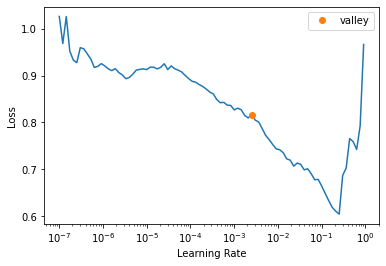

In [ ]:
tab_learn = tabular_learner(dls=tab_dls, layers=[200,100], metrics=metrics)
lr=list(tab_learn.lr_find())[0]
tab_learn.fit_flat_cos(100, cbs=[EarlyStoppingCallback()], lr=lr)

## Build Text Classifier

### Text DataLoader

In [ ]:
# language model dataloaders
dls_lm = TextDataLoaders.from_df(df,
                                 path=path,
                                 text_col=text_names, 
                                 is_lm=True, 
                                 label_col=y_names, 
                                 bs=64)

# text-classification dataloaders
txt_dls = TextDataLoaders.from_df(df, 
                                 path=path, 
                                 text_col=text_names,
                                 label_col=y_names, 
                                 bs=64, 
                                 text_vocab = dls_lm.vocab,
                                 )
txt_dls.show_batch()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos xxfld 1 xxmaj it 's huge . xxfld 2 xxmaj no , but i 'm not a small person . i 'm 5'8 , a size 6 on top , 8 on bottom . i do n't love this on the model online , but i saw this on xxunk 's blog , love xxunk , and thought it looked amazing . i tried it on in my retailer , and while they only had a m / l , since i 'm tall , i figured that 'd be fine . oh . no . not fine . it 's huge . like , it could almost cover a twin bed . it was a couple inches longer on me than on the model , and does n't xxunk down in a drape nearly as well , so just looks , h xxrep 3 u ge . i",0
1,"xxbos xxfld 1 xxmaj so cute , but did n't work for me xxfld 2 xxmaj i 've never been so bummed a dress did n't work for me . this is so cute . i love that it 's got a bit of a sleeve . it 's one of those easy , pop - it - on - and - go pieces i 'd love to have in my closet . i 'm 5'2 "" and i tried on a 6p in the store and it was prefect except for the bust . the elastic xxunk in the front and i ca n't imaging this dress working on anyone with more than a b cup . ( i 'm a d and it looked ridiculous in the bodice ) . i tried on a 6 , and the proportions were all off . if the elastic went str",1
2,"xxbos xxfld 1 xxmaj agree with others ; not for long torsos xxfld 2 xxmaj like others , i think this is just lovely on so many levels . however … \r\n▁ xxrep 12 _ \r\n pros : \r\n - great color , will match with many things . \r\n - great design at the sleeves and overall . \r\n - the "" v - neck "" part is n't too low . \r\n - fabric is pretty comfortable and breathable for the most part . \r\n▁ xxrep 13 _ \r\n cons : \r\n - it is boxy / wide . for my height and weight , the medium fit well , but i noticed it made my torso look shorter . plus , i 'm a 36c ( not huge , but to retailer 's standards , i 've had issues with things b",1
3,"xxbos xxfld 1 xxmaj weird fit . xxfld 2 1 . i 'm 5'5 "" tall , 140 lbs and 38 ( 36d ) - xxunk 40 . i 'm normally a size 10 in most brands , and in maeve in the past . this dress was too tight across my waist and hips in a size 12 , so it runs very slim . \n\n 2 . this dress is very long waisted , so the top bunched up funny . \n\n 3 . the horizontal bar in the back is in the wrong place , and will not hide your bra strap . \n\n 4 . there are bra strap keep loops in the shoulders , but this is an off the shoulder top . \n\n 5 . the underarms bunched funny . \n\n 6 . the dress has h",0
4,"xxbos xxfld 1 xxmaj really wanted to like it , but … xxfld 2 xxmaj this top is so pretty in the photos , but it just did not work out for me . it is more of a pale pink color than off - white like in the photo and it just hung on me weird . i felt like it was true to size , but made me feel very boxy . i can say it was very well made , so maybe i 'm just not the right body type for it . for reference , i 'm 5'5 "" and 135lbs . the small fit perfectly , but was a bit too wide at the bottom for my taste . i was willing to spend the money if it would have been perfect , but i 'll sa",0
5,"xxbos xxfld 1 xxmaj warm dress , with a few issues . xxfld 2 xxmaj first , i love wool . if it 's 100 % wool , i love it . if wool is n't your thing , then this dress is n't for you . i ordered this dress online in the burgundy . it is not itchy . it falls above my knees and i am 5'3 "" . it is warm and cozy with pockets , which i love . with the sleeves being short , i am wearing a long , frilly cardigan over it . i ordered the small ( did not notice a size chart with this product ) . i am usually a size 4 or 6 . it fits great in the bodice , but runs large through the hips . however ,",1
6,"xxbos xxfld 1 xxmaj size down , but how far down ? tricky sizing . xxfld 2 xxmaj my store had only one of these , in a size xs ( i tend to be more of a s in most retailer items ) . it was roomy . i am 5'2 , 34d , & figured a petite small would be a perfect fit . i ordered the ps , it arrived today , & is still pretty big ! the sleeves ( which are quite flared ) ar

### Text Learner

In [ ]:
# language model
learn_lm = language_model_learner(dls_lm, AWD_LSTM, drop_mult = 0.3).to_fp16()
#learn_lm.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,fbeta_score,time
0,0.359945,0.291354,0.881201,0.872203,0.881201,0.872171,01:15
1,0.321439,0.296604,0.863530,0.860659,0.863530,0.833934,01:15


No improvement since epoch 0: early stopping


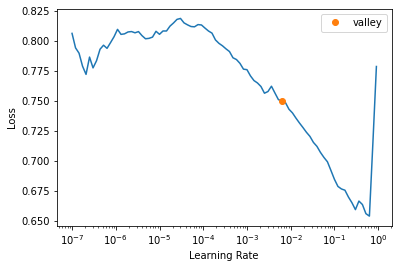

In [ ]:
txt_learn = text_classifier_learner(txt_dls, AWD_LSTM, drop_mult=0.5, metrics=metrics).to_fp16()
lr=list(txt_learn.lr_find())[0]
txt_learn.fit_flat_cos(100, cbs=[EarlyStoppingCallback()], lr=lr)

## Combine DataLoaders

> 'What we want to do is override both DataLoader's shuffle_fn, as what this function does is return a list of index's to grab. If the index's are the same, the data is the same, and that's all there is to it. In this particular case, we're going to be calling their shuffle_fn, etc multiple times, so we need to keep track of who actually is being called. We'll store this in a value called count. When it's 0, we'll grab some index's. When it's 1, we will return those index's (this is done at the beginning of each epoch to shuffle the DataLoader'

In [ ]:
from fastai.data.load import _loaders, _FakeLoader

class MixedDL():
    def __init__(self, tab_dls:TabularDataLoaders, txt_dls:TextDataLoaders, device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')):
        "Stores away `tab_dl` and `txt_dl`, and overrides `shuffle_fn`"
        self.device = device
        tab_dls.shuffle_fn = self.shuffle_fn
        txt_dls.shuffle_fn = self.shuffle_fn
        self.dls = [tab_dls, txt_dls]
        self.count = 0
        self.fake_l = _FakeLoader(self, False, 0, 0, persistent_workers=False) # persistent_workers: https://bowenroom.github.io/myBlog/pytorch/fastai/2021/01/27/fastai-dataloader.html
    
    def __len__(self): 
        """to return the length of one of our DataLoaders"""
        return len(self.dls[0])
        
    def shuffle_fn(self, idxs):
        "Generates a new list of index that will be stored inside `self.rng`; those indexs will be changed every 2 times shuffle_fn is called to ensure both tab_dls and txt_dls get the same set of indexs for batch."
        if self.count == 0: # if we haven't generated an rng yet
            self.rng = self.dls[0].rng.sample(idxs, len(idxs))
            self.count += 1
            return self.rng
        else:
            self.count = 0
            return self.rng
        
    def to(self, device): 
        """to set the name of device"""
        self.device = device

    def __iter__(self):
        """Iterate over your `DataLoader`
        iterator needs to 
        - take all of our batches from our loaders and 
        - perform the `after_batch` transform for those outputs from their respective `DataLoader` before finally being put into a batch, also 
        - moving each to the `device`.
        """
        z = zip(*[_loaders[i.fake_l.num_workers==0](i.fake_l) for i in self.dls])
        for b in z:
            if self.device is not None: 
                b = to_device(b, self.device)
            batch = []
            batch.extend(self.dls[0].after_batch(b[0])[:2]) # tabular cat and cont
            batch.append(self.dls[1].after_batch(b[1][0])) # text ???TBD
            try: # In case the data is unlabelled
                batch.append(b[1][1]) # y
                yield tuple(batch)
            except:
                yield tuple(batch)

    def one_batch(self):
        """Grab a batch from the `DataLoader`"""
        with self.fake_l.no_multiproc(): res = first(self)
        if hasattr(self, 'it'): delattr(self, 'it')
        return res

    def show_batch(self):
        "Show a batch from multiple `DataLoaders`"
        for dl in self.dls:
            dl.show_batch()

In [ ]:
mixed_dls = MixedDL(tab_dls, txt_dls)

In [ ]:
mixed_dls.show_batch()

,Clothing ID,Division Name,Department Name,Class Name,Rating,Age,Positive Feedback Count,Recommended IND
0,984,General,Jackets,Jackets,3.0,38.0,1.400000e+01,1
1,836,General Petite,Tops,Blouses,4.0,45.0,4.000000e+00,1
2,936,General,Tops,Sweaters,5.0,39.0,2.000000e+00,1
3,1072,General Petite,Dresses,Dresses,1.0,37.0,6.793806e-08,0
4,1092,General Petite,Dresses,Dresses,4.0,39.0,9.999999e-01,1
5,1078,General,Dresses,Dresses,3.0,57.0,9.999999e-01,1
6,1163,Initmates,Intimate,Sleep,5.0,46.0,6.793806e-08,1
7,886,General Petite,Tops,Knits,3.0,54.0,9.999999e-01,1


,text,category
0,"xxbos xxfld 1 xxmaj it 's huge . xxfld 2 xxmaj no , but i 'm not a small person . i 'm 5'8 , a size 6 on top , 8 on bottom . i do n't love this on the model online , but i saw this on xxunk 's blog , love xxunk , and thought it looked amazing . i tried it on in my retailer , and while they only had a m / l , since i 'm tall , i figured that 'd be fine . oh . no . not fine . it 's huge . like , it could almost cover a twin bed . it was a couple inches longer on me than on the model , and does n't xxunk down in a drape nearly as well , so just looks , h xxrep 3 u ge . i",0
1,"xxbos xxfld 1 xxmaj ideal fit and feel for gals with curves xxfld 2 xxmaj with my 5'9 ' , hourglass frame , wider hips and having a baby , i wear normally sizes 10 / 12 ( m / l ) in most retailer skirts and dresses . however , with this , i was able to fit into an 8 ; it just sat higher up and was too form fitting for my liking . here are my thoughts : \n▁ xxrep 9 _ \n pros : \n - lots of stretch and comfort . \n - pockets ! always a plus in my book :) \n - will go with any top . \n - nice length . fit me as in the model . \n - very slimming . \n - you could probably go down a size if you are slender with not wide hi",1
2,"xxbos xxfld 1 xxmaj so sad ! this year 's pant is s xxrep 3 o much shorter ! xxfld 2 i ordered first the green , then the grey ( in case the green was xxunk . ) \r\n so short ! ! \r\n is this to be in keeping with the ankle pant trend ? ? \r\n anyone who wants a shorter pant could easily hem them . but there is no way to lengthen them . \r\n i held the new pants up to an older pair from previous years . they are a full 2 1 / 2 inches shorter ! wow ! \r\n note how in the photo of the golden color pants they barely skim the model 's ankle . that 's how they are in real life . \r\n i wear these pants in a tall , and live",0
3,"xxbos xxfld 1 xxmaj love it , it 's much longer on me xxfld 2 i just got this in xs / s at my store and i love it . i have a petite frame ( 5'3 "" , + / - 105 lbs ) so it 's much longer on me than on the models . and the one i got is much more saturated with dye on the front than what 's shown in retailer 's pics , so that may vary a bit . however , the back of mine looks exactly like what 's shown above . i love the drape and the way it falls on me ; super casual - chic in my opinion . i 'd say the color is deep teal . wish it was n't hand wash , but sometimes that 's worth it .",1
4,"xxbos xxfld 1 xxmaj poorly made , static , and too tight . xxfld 2 1 . i like a shorter jacket , but this one was poorly made and poorly fit . \n\n 2 . the sleeves were way too tight . i 'm a size 10 or 12 , and the large which would be a 14 had tight sleeves that wrinkled up my arms , and the hem of the sleeve turned inside out . \n\n 3 . i ordered both a medium ( size 10 ) and a large ( size 14 ) , and neither hung right . the m too tight , and the large too loose in the body and too tight in the sleeves . \n\n 4 . very polyester with lots of static . \n\n 5 . cute idea , but not very good in pe",0
5,"xxbos xxfld 1 xxmaj beautiful one - of - a - kind jacket xxfld 2 i love this coat ! i purchased the size 6 . i am a size 6 petite , but they were out . plus i wanted the coat to be a little longer . i was n't a fan of how high it was on the model . it fit as i expected . i will have to take up the arm length , and it hit a little longer than it did on the model . i am 5 ' 120 pounds . 34c \n\n the quality is what i expected . it 's excellent with lining . color is as shown . this coat will go with everything ! i plan to dress it up and down . i purchased the "" orange "" pants and the",1
6,"xxbos xxfld 1 xxmaj weird fit . xxfld 2 1 . i 'm 5'5 "" tall , 140 lbs and 38 ( 36d ) - xxunk 40 . i 'm normally a size 10 in most brands , and in maeve in the past . this dress was too tight across my waist and hips in a size 12 , so it runs very slim . \n\n 2 . this dress is very long waisted , so the top bunched up funny . \n\n 3 .

In [ ]:
#dbck mixed_dls line up tabular & text correctly
mixed_dl = MixedDL(tab_dls[0], txt_dls[0])

In [ ]:
mixed_dl.dls[0].get_idxs()[:10]

[13018, 8442, 16783, 15531, 5136, 9720, 15411, 10051, 5429, 438]

In [ ]:
mixed_dl.dls[1].get_idxs()[:10]

[13018, 8442, 16783, 15531, 5136, 9720, 15411, 10051, 5429, 438]

The above shows that the data is being shuffled the exact same way for `tab_dls` and `txt_dls`.


Now let's exam `.one_batch()`: one_batch will need to call the first from the DataLoader (which is just next(iter(dl))), and if we are keeping track of an iterator, delete it. Finally returning our batch



In [ ]:
batch = mixed_dls.one_batch()

batch[0]

Exception ignored in: <generator object MixedDL.__iter__ at 0x7f4fee64de50>
RuntimeError: generator ignored GeneratorExit


tensor([[ 896,    1,    4,    7],
        [ 752,    2,    5,    1],
        [ 850,    1,    5,   18],
        [ 984,    2,    2,    4],
        [1004,    2,    2,    4],
        [ 990,    1,    2,    4],
        [1071,    3,    3,   17],
        [ 801,    2,    5,    9]])

In [ ]:
batch[1]

tensor([[-1.0735, -0.4245,  2.0138],
        [-0.1742,  0.1461,  0.2588],
        [ 0.7251, -0.3430, -0.0922],
        [-2.8720, -0.5060, -0.4432],
        [-0.1742, -0.3430, -0.2677],
        [-1.0735,  1.1241, -0.2677],
        [ 0.7251,  0.2276, -0.4432],
        [-1.0735,  0.8796, -0.2677]])

In [ ]:
batch[2]

TensorText([[   2,    4,   20,  ...,   12,  153,    0],
        [   2,    4,   20,  ...,   10,  290,  299],
        [   2,    4,   20,  ...,   15,   75, 1838],
        ...,
        [   2,    4,   20,  ...,   89,    1,    1],
        [   2,    4,   20,  ...,  313,    1,    1],
        [   2,    4,   20,  ..., 5139,    1,    1]], device='cuda:0')

In [ ]:
batch[3]

TensorCategory([0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')

### Train+Valid MixedDL

In [ ]:
train_mixed_dl = MixedDL(tab_dls[0], txt_dls[0])
valid_mixed_dl = MixedDL(tab_dls[1], txt_dls[1])
mixed_dls = DataLoaders(train_mixed_dl, valid_mixed_dl).cuda()

### Joint Model

In [ ]:
o=mixed_dls.one_batch() 
len(o)

Exception ignored in: <generator object MixedDL.__iter__ at 0x7f4fef1dbf50>
RuntimeError: generator ignored GeneratorExit


4

### Pytorch Hooks

To extract the input to the layer just before the classifier layer, creat 2 hooks:

In [ ]:
global glb_tab_logits
def get_tab_logits(self, inp, out):
    global glb_tab_logits
    glb_tab_logits = inp
    #return None

global glb_txt_logits
def get_txt_logits(self, inp, out):
    global glb_txt_logits
    glb_txt_logits = inp

### Define Multi-Modal Model
**Classifiers**
Used the default tabular and text classifiers from fastai and just grabbed the logits from each (via pytorch hooks) which are then concated and fed into a linear layer (which is our mixed classifier)

**PyTorch Hooks**
Note, I'm not sure if I'm grabbing the right thing with the get_tab_logits and get_txt_logits hooks, only grabbing the weight. Its trains ok tho, so maybe its fine

In [ ]:
class TabTxt(nn.Module):
    def __init__(self, tab_model, txt_model, num_classes=2, device='cuda:0'): 
        super(TabTxt, self).__init__()
        self.tab_model = tab_model
        self.txt_model = txt_model
        
        self.mixed_cls = nn.Linear(512+100, num_classes)
        self.tab_cls = nn.Linear(100, num_classes)
        self.txt_cls = nn.Linear(512, num_classes)
        
        #self.print_handle = self.tab_model.layers[2][0].register_forward_hook(printnorm)
        #tab_model.layers[2]
        #txt_model[1].layers[1][2]
        
        self.tab_handle = self.tab_model.layers[2].register_forward_hook(get_tab_logits)
        self.txt_handle = self.txt_model[1].layers[1][2].register_forward_hook(get_txt_logits)
        self.device=device

    def remove_my_hooks(self):
        self.tab_handle.remove()
        self.txt_handle.remove()
        #self.print_handle.remove()
        return None
        
    def forward(self, x_cat, x_cont, x_txt):
        # Tabular Classifier
        tab_pred = self.tab_model(x_cat.to(self.device), x_cont.to(self.device))        
        
        # Text Classifier
        txt_pred = self.txt_model(x_txt.to(self.device))
        
        # Logits
        tab_logits = glb_tab_logits[0]   # Only grabbling weights, not bias'
        txt_logits = glb_txt_logits[0]   # Only grabbling weights, not bias'
        mixed = torch.cat((tab_logits, txt_logits), dim=1)
        
        # Mixed Classifier
        mixed_pred = self.mixed_cls(mixed)
        return (tab_pred, txt_pred, mixed_pred)

### Gradient Blending, loss function

Same as : https://forums.fast.ai/t/gradient-blending-for-multi-modal-models-in-progress/75645/3

In [ ]:
def ModCELoss(pred, targ, ce=True):
    pred = pred.softmax(dim=-1)
    targ = targ.flatten().long()
    if ce:
        loss = F.cross_entropy(pred, targ)
    else:
        loss = F.binary_cross_entropy_with_logits(pred, targ)
    #loss = torch.mean(ce)
    return loss

class myGradientBlending(nn.Module):
    def __init__(self, tab_weight=0.0, txt_weight=0.0, tab_txt_weight=1.0, loss_scale=1.0, use_cel=True):
        "Expects weights for each model, the combined model, and an overall scale"
        super(myGradientBlending, self).__init__()
        self.tab_weight = tab_weight
        self.txt_weight = txt_weight
        self.tab_txt_weight = tab_txt_weight
        self.ce =  use_cel
        self.scale = loss_scale
        
    def forward(self, xb, yb):
        tab_out, txt_out, tv_out = xb
        targ = yb
        "Gathers `self.loss` for each model, weighs, then sums"
        tv_loss = ModCELoss(tv_out, targ, self.ce) * self.scale
        t_loss = ModCELoss(tab_out, targ, self.ce) * self.scale
        v_loss = ModCELoss(txt_out, targ, self.ce) * self.scale
        
        weighted_t_loss = t_loss * self.tab_weight
        weighted_v_loss = v_loss * self.txt_weight
        weighted_tv_loss = tv_loss * self.tab_txt_weight
        
        loss = weighted_t_loss + weighted_v_loss + weighted_tv_loss
        return loss

### testing individual steps

In [ ]:
multi_model = TabTxt(tab_learn.model, txt_learn.model)

In [ ]:
o[0].shape, o[1].shape , o[2].shape

(torch.Size([8, 4]), torch.Size([8, 3]), torch.Size([64, 124]))

In [ ]:
tab_pred, txt_pred, mixed_pred = multi_model(o[0], o[1] , o[2])

RuntimeError: ignored

In [ ]:
%debug

###  testing learner

In [ ]:

def t_accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
#     print(inp[0])
#     print(inp[0].argmax(dim=axis))
#     print(targ)
    pred,targ = flatten_check(inp[0].argmax(dim=axis), targ)
    return (pred == targ).float().mean()

def v_accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp[1].argmax(dim=axis), targ)
    return (pred == targ).float().mean()

def tv_accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp[2].argmax(dim=axis), targ)
    return (pred == targ).float().mean()

def weighted_accuracy(inp, targ, axis=-1, w_t=0.333, w_v=0.333, w_tv=0.333):
    t_inp = inp[0] * w_t
    v_inp = inp[1] * w_v
    tv_inp = inp[2] * w_tv
    inp_fin = (t_inp + v_inp + tv_inp)/3
    pred,targ = flatten_check(inp_fin.argmax(dim=axis), targ)
    return (pred == targ).float().mean()

### Testing: train Tabular learner

In [ ]:
tab_learn = tabular_learner(tab_dls, metrics=metrics)
tab_learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,fbeta_score,time
0,0.245436,0.187490,0.924223,0.921507,0.924223,0.919536,00:37
1,0.213827,0.175376,0.934440,0.940064,0.934440,0.936309,00:36
2,0.216927,0.169153,0.935292,0.938765,0.935292,0.936582,00:36


### Testing: train Text learner

In [ ]:
txt_learn = text_classifier_learner(txt_dls, AWD_LSTM, drop_mult=0.5, metrics=metrics).to_fp16()
txt_learn.fit_one_cycle(1, 0.02)


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,fbeta_score,time
0,0.386474,0.290032,0.869065,0.858423,0.869065,0.850416,01:43


### Testing: train mixed learner

In [ ]:
# Get uni-modal models, ugly but quick way to grab a tabular and vision model
txt_model = text_classifier_learner(txt_dls, AWD_LSTM, drop_mult=0.5, metrics=metrics).model
tab_model = tabular_learner(tab_dls, metrics=accuracy).model

# Create our Multi-Modal model
multi_model = TabTxt(tab_model, txt_model)

# Set weights for each loss
tab_w = 0.15
txt_w = 0.6
tt_w = 0.25

# Initialise Loss
gb_loss = myGradientBlending(tab_weight=tab_w, txt_weight=txt_w, tab_txt_weight=tt_w, 
                             loss_scale=1.0, use_cel=True)

# Define accuracy weights
w_accuracy = partial(weighted_accuracy, w_t=tab_w, w_v=txt_w, w_tt=tt_w)

metrics = [t_accuracy,v_accuracy,tv_accuracy, w_accuracy]
cbs=[]

In [ ]:
txt_model

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(6928, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(6928, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True)


In [ ]:
tab_model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1108, 81)
    (1): Embedding(4, 3)
    (2): Embedding(7, 5)
    (3): Embedding(21, 9)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=101, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)

In [ ]:
multi_learn = Learner(mixed_dls, multi_model, gb_loss, cbs=cbs, metrics=metrics)

In [ ]:
multi_learn.fit_one_cycle(3, 0.02)



epoch,train_loss,valid_loss,t_accuracy,v_accuracy,tv_accuracy,weighted_accuracy,time


Exception ignored in: <generator object MixedDL.__iter__ at 0x7f4fef3a88d0>
RuntimeError: generator ignored GeneratorExit


RuntimeError: ignored

In [ ]:
%debug

In [ ]:
lr=list(tab_learn.lr_find())[0]
multi_learn.fit_flat_cos(100, cbs=[EarlyStoppingCallback()], lr=lr)

In [ ]:
# Remove hooks from model (not sure if this is working)
multi_learn.model.remove_my_hooks()

In [ ]:
multi_learn.recorder.plot_loss()